# Overview

This notebook presents a post-processing and analysis workflow for MICE-derived mutual information data for Na and Al.

It first constructs entropy differences between solid and liquid phases by aggregating and integrating mutual information outputs over block iterations, and exporting the resulting quantities to CSV files. It then visualizes and compares these thermodynamic quantities (e.g., \(\Delta g_{S \rightarrow L}(T)\), \(T_m \Delta s\), and \(\Delta h\)) across MD, MetaD, and MICE methodologies, alongside experimental reference values.


# Construction of entropy differences from MI data

This cell imports the preprocessed MICE mutual information data from `pd_MICE.csv`, defines element-specific parameters, and introduces auxiliary functions for computing volume and surface scaling, as well as for aggregating the data.

In detail, it:
- Filters the dataset for each element and phase (solid and liquid) at the prescribed style and block factor.
- Constructs, for each iteration, records of the mutual information (MI) and per-atom MI differences between phases, including the associated propagated standard deviations.
- Integrates the MI differences (with an extrapolation based on the first block) to obtain entropy differences `ddeltaMI` for each element.
- Writes per-element analysis CSV files (`df_<element>_mice.csv`) and a summary file `ddeltaMI.csv`, and returns the `ddeltaMI` DataFrame for subsequent inspection.


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd

PD_MICE_CSV = Path("../train/pd_MICE.csv")
ELEMENT_CONFIG = {
    "Na": {
        "bf": 0.4,
        "edge_factor": 4.228,
        "defaults": {"S": 60.764, "L": 59.873},
        "temp": 365,
    },
    "Al": {
        "bf": 0.3,
        "edge_factor": 4.05,
        "defaults": {"S": 59.03, "L": 56.05},
        "temp": 900,
    },
}
TARGET_STYLE = "val"
PHASE_PAIR = ("S", "L")
NUM_SEEDS = 5
MAX_FRAMES = 1000
OUTPUT_DIR = Path("../train/results/analysis")
OUTPUT_CSV_DIR = Path("analysis/mice")

if not PD_MICE_CSV.exists():
    raise FileNotFoundError(f"Missing parsed CSV: {PD_MICE_CSV}")

pd_MICE = pd.read_csv(PD_MICE_CSV)
required_cols = {"bf", "dims", "phase", "style", "MI", "binx", "biny", "binz", "element"}
missing = required_cols - set(pd_MICE.columns)
if missing:
    raise ValueError(f"pd_MICE CSV missing columns: {sorted(missing)}")


def calc_A(edge: float, n: int) -> np.ndarray:
    values = [edge * edge]
    for idx in range(1, n):
        values.append(values[-1] if idx % 3 == 0 else values[-1] / 2)
    return np.asarray(values)


def load_phase_array(path: Path | None, max_frames: int | None = None):
    if path is None:
        return None
    if not path.exists():
        print(f"Warning: {path} not found; falling back to defaults")
        return None
    data = np.load(path, mmap_mode="r")
    return data[:max_frames] if max_frames is not None else data


def prepare_pd_mice(df: pd.DataFrame) -> pd.DataFrame:
    group_cols = ["bf", "dims", "phase", "style", "element"]
    df = df.copy()
    df["stdev"] = df.groupby(group_cols)["MI"].transform("std").fillna(0.0)
    agg_cols = group_cols + ["binx", "biny", "binz"]
    return df.groupby(agg_cols)[["MI", "stdev"]].mean().reset_index()


pd_MICE_avg = prepare_pd_mice(pd_MICE)

results = {}

for element, cfg in ELEMENT_CONFIG.items():
    elem_df = pd_MICE_avg[pd_MICE_avg["element"] == element]
    if elem_df.empty:
        print(f"No data found for {element}, skipping...")
        continue

    bf = cfg["bf"]
    edge_factor = cfg["edge_factor"]
    defaults = cfg["defaults"]
    temp = cfg["temp"]

    phase_S, phase_L = PHASE_PAIR
    subset_S = elem_df[
        (elem_df["bf"] == bf)
        & (elem_df["style"] == TARGET_STYLE)
        & (elem_df["phase"] == phase_S)
    ].sort_values(["binx", "biny", "binz"]).reset_index(drop=True)
    subset_L = elem_df[
        (elem_df["bf"] == bf)
        & (elem_df["style"] == TARGET_STYLE)
        & (elem_df["phase"] == phase_L)
    ].sort_values(["binx", "biny", "binz"]).reset_index(drop=True)

    if subset_S.empty or subset_L.empty:
        print(f"No matching rows for {element} with bf={bf}, style={TARGET_STYLE}, phases={PHASE_PAIR}")
        continue
    if len(subset_S) != len(subset_L):
        raise ValueError(f"Phase subsets need the same length for {element}")

    len_MI = len(subset_S)
    powers_of_2 = np.array([2 ** i for i in range(len_MI)])
    edge = edge_factor * 8 * bf
    box_volume = edge ** 3
    
    # Pre-compute volume and area arrays (volume scales as 1/2^i per iteration)
    Vs = box_volume / powers_of_2
    As = calc_A(edge, len_MI)

    MIsS = subset_S["MI"].values[::-1]
    MIsL = subset_L["MI"].values[::-1]
    stdS = subset_S["stdev"].values[::-1]
    stdL = subset_L["stdev"].values[::-1]
    binx_vals = subset_S["binx"].values[::-1]
    biny_vals = subset_S["biny"].values[::-1]
    binz_vals = subset_S["binz"].values[::-1]
    combined_std = np.sqrt(stdS ** 2 + stdL ** 2)

    # Base atom counts from config
    nAtomsS_base = defaults["S"]
    nAtomsL_base = defaults["L"]
    
    # Scale atom counts by volume reduction (proportional to 1/2^i)
    nAtomsS_scaled = nAtomsS_base / powers_of_2
    nAtomsL_scaled = nAtomsL_base / powers_of_2

    records_diff2 = []

    for i in range(len_MI):

        record_common = {
            "iter": i,
            "element": element,
            "bf": bf,
            "MI_S": MIsS[i],
            "MI_L": MIsL[i],
            "stdev_S": stdS[i],
            "stdev_L": stdL[i],
            "temp": temp,
            "binx": binx_vals[i],
            "biny": biny_vals[i],
            "binz": binz_vals[i],
        }

        nAtomsS_i = nAtomsS_scaled[i]
        nAtomsL_i = nAtomsL_scaled[i]
        
        records_diff2.append(
            record_common
            | {
                "nAtomsS": nAtomsS_i,
                "nAtomsL": nAtomsL_i,
                "MI_S_perAtom": MIsS[i] / nAtomsS_i if np.isfinite(nAtomsS_i) else np.nan,
                "MI_L_perAtom": MIsL[i] / nAtomsL_i if np.isfinite(nAtomsL_i) else np.nan,
                "MI_S_perAtom_std": stdS[i] / nAtomsS_i if np.isfinite(nAtomsS_i) else np.nan,
                "MI_L_perAtom_std": stdL[i] / nAtomsL_i if np.isfinite(nAtomsL_i) else np.nan,
                "MI_perAtom_diff": (MIsS[i] / nAtomsS_i - MIsL[i] / nAtomsL_i) if np.isfinite(nAtomsS_i) and np.isfinite(nAtomsL_i) else np.nan,
                "MI_perAtom_diff_std": combined_std[i] / nAtomsS_i if np.isfinite(nAtomsS_i) else np.nan,
                "MI2_perAtom_diff": (MIsS[i] / nAtomsS_base - MIsL[i] / nAtomsL_base) * powers_of_2[i] if np.isfinite(nAtomsS_base) and np.isfinite(nAtomsL_base) else np.nan,
                "MI2_perAtom_diff_std": combined_std[i] / nAtomsS_base * powers_of_2[i] if np.isfinite(nAtomsS_base) else np.nan,
            }
        )

    results[element] = pd.DataFrame(records_diff2)
    print(f"Processed {element}: {len(records_diff2)} iterations")

# Calculate ddeltaMI for each element
kbNa = 8.314462618e-3
ddeltaMI_records = []

for element, df_elem in results.items():
    cfg = ELEMENT_CONFIG[element]
    temp = cfg["temp"]
    bf = cfg["bf"]
    
    S_jkmol = kbNa * df_elem["MI2_perAtom_diff"].sum()
    S_jkmol_std = kbNa * np.sqrt((df_elem["MI2_perAtom_diff_std"] ** 2).sum())
    
    M0_V = df_elem["MI2_perAtom_diff"].values[0]
    M0_V_std = df_elem["MI2_perAtom_diff_std"].values[0]
    
    ddeltaMI_records.append({
        "element": element,
        "temp": temp,
        "bf": bf,
        "s_diff": S_jkmol,
        "s_diff_std": S_jkmol_std,
        "3M0_V*kbNa": 3 * M0_V * kbNa,
        "3M0_V*kbNa_std": 3 * M0_V_std * kbNa,
        "s_extrapol": S_jkmol + 3 * M0_V * kbNa,
        "s_extrapol_std": np.sqrt(S_jkmol_std ** 2 + (3 * M0_V_std * kbNa) ** 2),
    })

ddeltaMI = pd.DataFrame(ddeltaMI_records)

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_CSV_DIR.mkdir(parents=True, exist_ok=True)

for element, df_elem in results.items():
    out_csv = OUTPUT_CSV_DIR / f"df_{element}_mice.csv"
    df_elem.to_csv(out_csv, index=False)
    print(f"Saved {element} analysis CSV to {out_csv} ({len(df_elem)} rows)")

ddeltaMI_csv = OUTPUT_CSV_DIR / "ddeltaMI.csv"
ddeltaMI.to_csv(ddeltaMI_csv, index=False)
print(f"Saved ddeltaMI CSV to {ddeltaMI_csv}")

print(f"\nSummary: Generated {len(results)} analysis files + ddeltaMI")
ddeltaMI


# Visualization of thermodynamic quantities
 
Comparison the thermodynamic properties of Na and Al obtained from three methodologies: MD, MetaD, and MICE.
- For Na and Al, construct temperature-dependent curves for $\Delta g_{S \rightarrow L}(T)$ from MD, MetaD, and MICE (using enthalpy/entropy estimates and their uncertainties).
- Produce bar plots that compare $T_m \Delta s$ and $\Delta h$ across MD, MetaD, and MICE, and contrast these with experimental reference values.



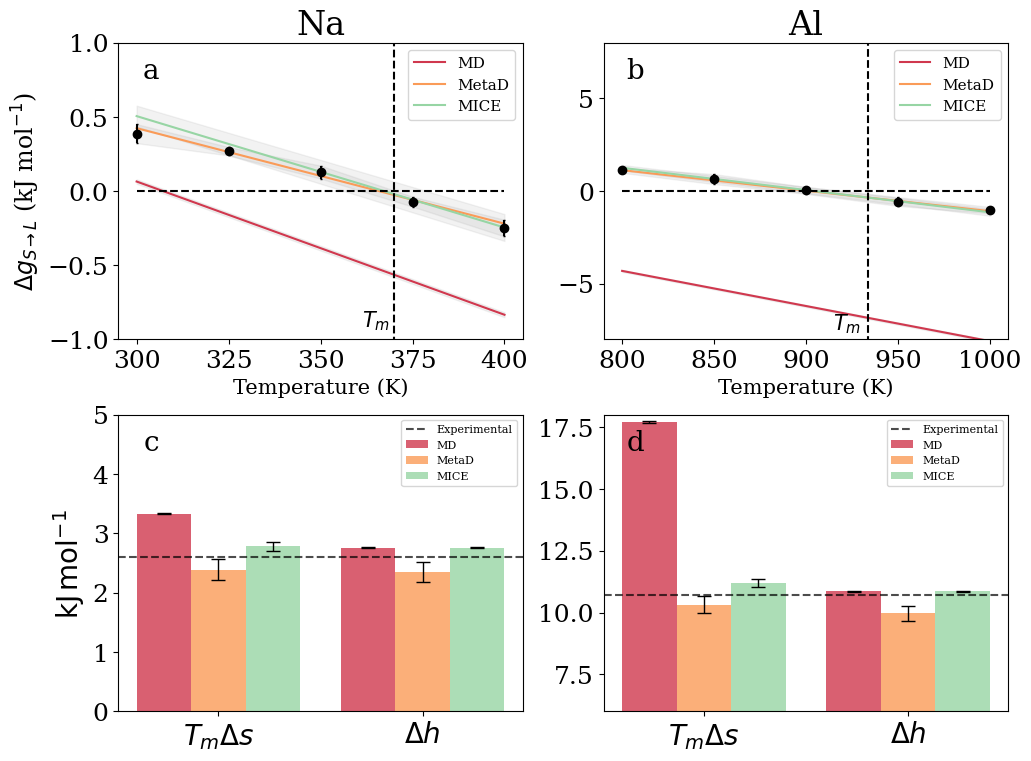

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from pathlib import Path
import numpy as np
import pandas as pd

fontsize = 20
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 20,
    "axes.labelsize": 22,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

fig = plt.figure(figsize=(10.2, 7.5), constrained_layout=True)

def plot_with_error(ax, x, dx, y, dy, legend, color, linestyle='-'):
    ax.plot(x, y, linestyle=linestyle, label=legend, color=color)
    ax.fill_between(x, y-dy, y+dy, alpha=0.1, color='grey')

def scatter_with_error(ax, xo, yo, yoerr, legend, color, start=0, end=-1):
    popt, pcov = curve_fit(
        lambda x, m, c: m*x + c,
        xo[start:end], yo[start:end],
        sigma=yoerr[start:end], absolute_sigma=False
    )
    perr = np.sqrt(np.diag(pcov))
    ax.plot(xo, np.poly1d(popt)(xo), label=legend, color=color)
    ax.errorbar(xo, yo, yoerr,
                marker='o', linestyle='none',
                color='black', ecolor='black', capsize=1)
    ax.fill_between(xo, yo-yoerr, yo+yoerr, alpha=0.1, color='grey')
    return popt, perr

colors = sns.color_palette("Spectral", 10)
colors = [colors[i] for i in [0, 2, 7, 8, 9]]

ax1 = plt.subplot(2, 2, 1)
T = np.linspace(300, 400, 100)
vals_na = []

dS_MD = 0.00897961962744
dS_MD_er = 0.000016628925236
dH_MD = 2.75810666
dH_MD_er = 0.0100188925
y_MD = dH_MD - T * dS_MD
y_MD_err = dH_MD_er + T * dS_MD_er
plot_with_error(ax1, T, dS_MD_er, y_MD, y_MD_err, 'MD', colors[0])
vals_na.append({"exp": "MD", "dS": dS_MD, "dS_er": dS_MD_er, "dH": dH_MD, "dH_er": dH_MD_er})

temp = np.array([300, 325, 350, 375, 400])
deltaG = np.array([0.38693937264, 0.26835502524, 0.12779126392, -0.07143644316, -0.2496289286])
devs = np.array([0.06402755272, 0.02837684176, 0.0436406806, 0.03320111164, 0.05624600676])
popt, perr = scatter_with_error(ax1, temp, deltaG, devs, 'MetaD', colors[1])
vals_na.append({"exp": "MetaD", "dS": -popt[0], "dS_er": perr[0], "dH": popt[1], "dH_er": perr[1]})

dS_Mice = 0.0075
dS_Mice_er = 0.000201
dH_Mice = 2.75810666
dH_Mice_er = 0.0100188925
y_Mice = dH_Mice - T * dS_Mice
y_Mice_err = dH_Mice_er + T * dS_Mice_er
plot_with_error(ax1, T, dS_Mice_er, y_Mice, y_Mice_err, 'MICE', colors[2])
vals_na.append({"exp": "MICE", "dS": dS_Mice, "dS_er": dS_Mice_er, "dH": dH_Mice, "dH_er": dH_Mice_er})

ax1.hlines(0, 300, 400, linestyle='--', color='black')
ax1.vlines(370, -2, 2, linestyle='--', color='black')
ax1.text(365, -0.95, r"$T_m$", fontsize=fontsize-5, color='black', ha='center', va='bottom')
ax1.set_xlabel('Temperature (K)', fontsize=fontsize-5)
ax1.set_ylabel(r'$\Delta g_{S \rightarrow L}$ (kJ mol$^{-1}$)', fontsize=fontsize-3)
ax1.set_ylim(-1, 1)
ax1.legend(loc='upper right', fontsize=fontsize-9)
ax1.set_title('Na')

ax2 = plt.subplot(2, 2, 2)
T = np.linspace(800, 1000, 100)
vals_al = []

dS_MD = 0.01894658818
dS_MD_er = 0.000042841843
dH_MD = 10.8531848
dH_MD_er = 0.0184040585
y_MD = dH_MD - T * dS_MD
y_MD_err = dH_MD_er + T * dS_MD_er
plot_with_error(ax2, T, dS_MD_er, y_MD, y_MD_err, 'MD', colors[0])
vals_al.append({"exp": "MD", "dS": dS_MD, "dS_er": dS_MD_er, "dH": dH_MD, "dH_er": dH_MD_er})

temp = np.array([800, 850, 900, 950, 1000])
deltaG = np.array([1.1131517057105468, 0.6462376732396691, 0.03435882818543423, -0.5643136263910937, -1.028535051494245])
devs = np.array([0.13120526056247266, 0.2699028567526278, 0.18612059271369408, 0.23784518622588636, 0.17383845331600746])
popt, perr = scatter_with_error(ax2, temp, deltaG, devs, 'MetaD', colors[1])
vals_al.append({"exp": "MetaD", "dS": -popt[0], "dS_er": perr[0], "dH": popt[1], "dH_er": perr[1]})

dS_Mice = 0.012
dS_Mice_er = 0.00016566666666666666
dH_Mice = 10.8531848
dH_Mice_er = 0.0184040585
y_Mice = dH_Mice - T * dS_Mice
y_Mice_err = dH_Mice_er + T * dS_Mice_er
plot_with_error(ax2, T, dS_Mice_er, y_Mice, y_Mice_err, 'MICE', colors[2])
vals_al.append({"exp": "MICE", "dS": dS_Mice, "dS_er": dS_Mice_er, "dH": dH_Mice, "dH_er": dH_Mice_er})

ax2.hlines(0, 800, 1000, linestyle='--', color='black')
ax2.vlines(933.5, -10, 10, linestyle='--', color='black')
ax2.set_xlabel('Temperature (K)', fontsize=fontsize-5)
ax2.set_ylim(-8, 8)
ax2.legend(loc='upper right', fontsize=fontsize-9)
ax2.set_title('Al')
ax2.text(922, -7.8, r"$T_m$", fontsize=fontsize-5, color='black', ha='center', va='bottom')

ax3 = plt.subplot(2, 2, 3)
df = pd.DataFrame(vals_na)
dS_exp = 0.007017
dS_exp_er = 0.000001
dH_exp = 2.603
dH_exp_er = 0.001
theory = [dS_exp, dH_exp]

type_order = [r"$T_m \Delta s$", r"$\Delta h$"]
hue_order = list(df["exp"])

plot_data = pd.DataFrame({
    "Type": np.repeat(type_order, len(df)),
    "Experiment": hue_order * 2,
    "Value": np.concatenate([370.9*df["dS"], df["dH"]]),
    "Error": np.concatenate([370.9*df["dS_er"], df["dH_er"]]),
})

pivot_val = plot_data.pivot(index="Type", columns="Experiment", values="Value").loc[type_order, hue_order]
pivot_err = plot_data.pivot(index="Type", columns="Experiment", values="Error").loc[type_order, hue_order]

x = np.arange(len(type_order))
n_exp = len(hue_order)
width = 0.8 / n_exp
for i, exp in enumerate(hue_order):
    offsets = x + (i - (n_exp-1)/2) * width
    vals = pivot_val[exp].values
    errs = pivot_err[exp].values
    ax3.bar(offsets, vals, width=width, color=colors[i], alpha=0.8, label=exp)
    ax3.errorbar(offsets, vals, yerr=errs, fmt="none", ecolor="black", capsize=5, linewidth=1, zorder=10)

ax3.axhline(theory[1], color="black", linestyle="--", alpha=0.7, label="Experimental")
ax3.set_xticks(x)
ax3.set_xticklabels(type_order, fontsize=fontsize)
ax3.set_ylim(0, 5)
ax3.set_xlabel("")
ax3.set_ylabel(r'$\mathrm{kJ\,mol^{-1}}$', fontsize=fontsize)
ax3.tick_params(axis="both")
ax3.legend(loc="upper right", fontsize=fontsize-12)

ax4 = plt.subplot(2, 2, 4)
df = pd.DataFrame(vals_al)
dS_exp = 0.011475
dS_exp_er = 0.000001
dH_exp = 10.711
dH_exp_er = 0.001
theory = [dS_exp, dH_exp]

type_order = [r"$T_m \Delta s$", r"$\Delta h$"]
hue_order = list(df["exp"])

plot_data = pd.DataFrame({
    "Type": np.repeat(type_order, len(df)),
    "Experiment": hue_order * 2,
    "Value": np.concatenate([933.5*df["dS"], df["dH"]]),
    "Error": np.concatenate([933.5*df["dS_er"], df["dH_er"]]),
})

pivot_val = plot_data.pivot(index="Type", columns="Experiment", values="Value").loc[type_order, hue_order]
pivot_err = plot_data.pivot(index="Type", columns="Experiment", values="Error").loc[type_order, hue_order]

x = np.arange(len(type_order))
n_exp = len(hue_order)
width = 0.8 / n_exp
for i, exp in enumerate(hue_order):
    offsets = x + (i - (n_exp-1)/2) * width
    vals = pivot_val[exp].values
    errs = pivot_err[exp].values
    ax4.bar(offsets, vals, width=width, color=colors[i], alpha=0.8, label=exp)
    ax4.errorbar(offsets, vals, yerr=errs, fmt="none", ecolor="black", capsize=5, linewidth=1, zorder=10)

ax4.axhline(theory[1], color="black", linestyle="--", alpha=0.7, label="Experimental")
ax4.set_xticks(x)
ax4.set_xticklabels(type_order, fontsize=fontsize)
ax4.set_ylim(6, 18)
ax4.set_xlabel("")
ax4.tick_params(axis="both")
ax4.legend(loc="upper right", fontsize=fontsize-12)

labels = ['a', 'b', 'c', 'd']
axes = [ax1, ax2, ax3, ax4]
for label, ax in zip(labels, axes):
    ax.text(+0.1, 0.95, label, transform=ax.transAxes, fontsize=20, fontweight=1, va='top', ha='right')

# output_path = Path('paper/figpdf/dgs.png')
# output_path.parent.mkdir(parents=True, exist_ok=True)
# plt.savefig(output_path, dpi=600)
plt.show()
